## Supervised Anomaly Detection
In our earlier lessons, we talked about different ways to find unusual patterns in data without using any extra information. The challenge with this unsupervised anomaly detection is that sometimes regular noise gets mislabeled as anomalies due to lack of knowledge. Now, what if you have examples of both anomalies and normal data? How does that change things?

**Knowledge is key**
- Make use of any (domain-specific) information you have regarding your anomalies.
- If you're extremely fortunate, you may have a straightforward selection criterion:
    - Every height greater than 6' 5" is anomalies.
- More often, information consists of examples of normal data and anomalies
- Extra information usually improves anomaly detection accuracy significantly

Note: `Whenever possible, use supervised methods.`

**A special case of classification**  
In general, supervised anomaly detection is a special case of classification problem.
- Examples of anomalies and normal points = training data
- Unlabeled points = test data
- Therefore, the many classification techniques available (supervised machine learning) can be used for anomaly detection

**A supervised anomaly detection may faced few problems**
1. Class Imbalance
    - Anomalies by definition are rare, so there will be few examples
2. Contaminated normal data
    - Only anomalies labeled; normal class contaminated by unlabeled anomalies
3. Partially labeled data (“semi-supervised anomaly detection”)
    - Typical case: only normal class labeled

**Illustration of Class Imbalance Problem**
- There's a test using X-ray scans to find a rare cancer.
- In the group taking the test, 99% are healthy, and only 1% have the cancer.
- We're making a computer program to decide if a scan is normal or anomalous.

Note: `Must evaluate algorithm performance with care`

Now, if we train an anomaly detector in this setting we might end up getting a useless anomaly detector. Because:
- Label all scans as normal without any analysis
- Confusion matrix will be:
![image](https://github.com/surajkarki66/Freyja/assets/50628520/24c4fc91-bf64-4808-8b2b-c6fc5b8f1478)
-  Accuracy = (0 + 99)/100 = 99%
- Very high accuracy, but never find a sick patient

**In order to perform effective anomaly detection with class imbalance dataset, we need to evaluate the algorithm effectively**

- When the anomalies represent a tiny percentage of the total data, overall accuracy is not a relevant metric to evaluate the algorithm.
- Typically, it is more costly to misclassify an anomalous point than normal data
    - For the cancer example: a false positive (normal point misclassified) will lead to additional, diagnostic tests, which hopefully will correct the error
    -  A false negative (anomalous point misclassified) will lead to overlooking the disease at an early, treatable stage and perhaps ignoring it until it is too late to treat.
- This cost should be included when evaluating the effectiveness of the algorithm

**Algorithm should take into account cost of making a mistake (misclassification)**
- Use a cost-weighted approach when implementing algorithm
- Two main ways to do so:
    - Cost-sensitive learning
    - Adaptive resampling

In [1]:
!pip install scikit-learn==1.2.2
!pip install mlxtend
!pip install imblearn

## 1. Imports

In [2]:
import warnings
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.svm import SVC
from collections import Counter
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import confusion_matrix, accuracy_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

%matplotlib inline
warnings.filterwarnings('ignore', category=FutureWarning)

## 2. Python and library versions

In [3]:
versions = ( ("matplotlib", matplotlib.__version__),
            ("numpy", np.__version__),
            ("pandas", pd.__version__))

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0] 

library    version
------------------
matplotlib  3.7.1
numpy       1.23.5
pandas      1.5.3


## Section 1: Cost-sensitive learning
- Classifier is trained using a weighted accuracy over the various classes.
- Consider two classes—normal (denoted by 0) and anomalies (denoted by 1)
- In this case minimize the weighted accuracy given by:
![image](https://github.com/surajkarki66/shortIT/assets/50628520/f1bb927c-6274-4cc4-bf19-103a3bdf6dca)
    - ci is cost of misclassifying a point from class i (with i = 0, 1)
    - ni is number of misclassified instances from class i

- The objective function above can be generalized to multiclass systems (different types of anomaly)

- The costs for each classes is often domain-dependent and should be specified as part of the inputs for the algorithm

- However, if no information about the costs is available, you have to make an educated guess.

- One possibility is

![image](https://github.com/surajkarki66/shortIT/assets/50628520/860e0c22-77a4-4dde-ad8a-1279d58c1388)

where Ni is the number of points in class i

![image](https://github.com/surajkarki66/shortIT/assets/50628520/c4954bb3-555f-448c-8aeb-819244b648c4)


We will proceed as follows:

1. Create the simulated data
2. Train our algorithm giving all data points equal weight
3. Examine the misclassifications using a confusion matrix
4. Repeat steps (2) and (3) using cost-sensitive learning and compare our results.

## 3. Data
We create the synthetic data using the *make_classification* function of sklean. We create 5000 points with approximately 90% normal points (label 0) and 10% anomalies (label 1).

In [4]:
# Generate synthetic imbalanced data
features, label = make_classification(n_samples=5000, n_features=2,
                                      n_informative=2, n_redundant=0,
                                      n_repeated=0, n_classes=2,
                                      n_clusters_per_class=1,
                                      weights=[0.90, 0.10], flip_y=0.01,
                                      class_sep=1.5, random_state=42)


For a detailed explanation of the *make_classification* parameters, see https://scikitlearn.org/stable/modules/generated/sklearn.datasets.make_classification.html.

Here we discuss a few of them.

We specify the initial weights of the normal and anomaly class to be 0.90 and 0.10 respectively using *weights*.

With *flip_y*, we specify the fraction of samples whose class are randomly exchanged to introduce some noise into the data.

And we use *class_sep* to specify the separation between the two classes; larger values spread out the classes.

In [5]:
df = pd.DataFrame(features, columns=['feature1', 'feature2'])
df['label'] = label

Plot the data and color code normal vs. anomaly. Here we use *lmplot* from *seaborn* as it offers a compact way to label points by class.

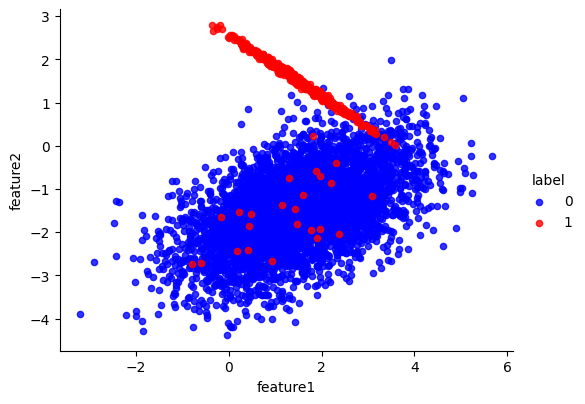

In [9]:
colors = ['blue', 'red']
sns.lmplot(data=df, x="feature1", y="feature2", hue='label',
           palette=colors, fit_reg=False, scatter_kws={'s': 20})
plt.gcf().set_size_inches(6,4);

In [10]:
# Plain tree as
tree_plain = DecisionTreeClassifier(max_depth=1, class_weight=None)

We will use plot_decision_regions from mlxtend to show the regions the classfier uses to assign class labels.

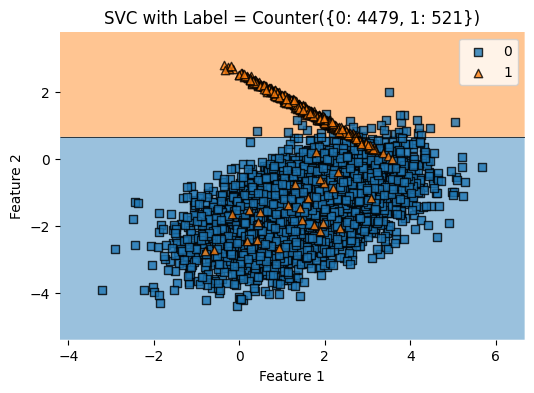

In [11]:
tree_plain_fit = tree_plain.fit(features, label)
plot_decision_regions(features, label, tree_plain_fit)
plt.title(f'SVC with Label = {Counter(label)}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')
plt.gcf().set_size_inches(6,4)

As expected, the two classes are separated by a single line as only one feature was used for the split.

Next, we examined the statistics of the classification.

In [12]:
cm_tree_plain=confusion_matrix(label, tree_plain.predict(features))
print(cm_tree_plain)
accuracy_tree_plain = accuracy_score(label, tree_plain.predict(features))
print(f'Accuracy: {accuracy_tree_plain}')

[[4442   37]
 [  47  474]]
Accuracy: 0.9832


We misclassified 37 normal points and 47 anomalies. Not bad, but let's try to improve this result.

To do so, we will introduce cost-sensitive learning. For our decision tree, cost-sensitive learning can be introduced through the parameter *class_weight*. In the previous analysis, this parameter was set to *None*, which means that all points were given equal weight.

In our next iteration, we will set *class_weight* to *balanced*. In this case, the weights are set inversely proportional to the frequency of the class. That is, the cost of making a mistake is inversely proportional to the number of instances of that class.

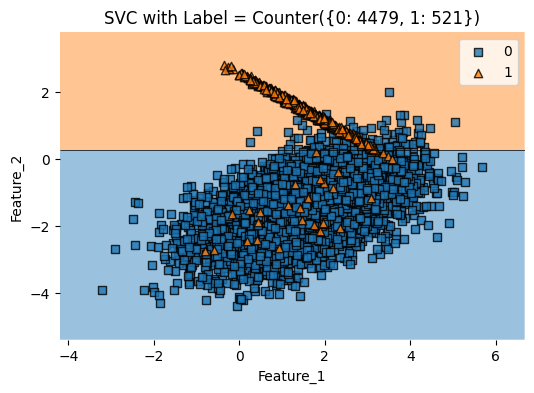

In [13]:
tree_bal = DecisionTreeClassifier(max_depth=1, class_weight='balanced')
tree_bal_fit = tree_bal.fit(features, label)
plot_decision_regions(features, label, tree_bal_fit)
plt.title(f'SVC with Label = {Counter(label)}')
plt.xlabel('Feature_1')
plt.ylabel('Feature_2')
plt.legend(loc='best')
plt.gcf().set_size_inches(6,4)

Notice that the boundary has moved. It is now closer to Feature_2 = 0. This is promising. It shows that the cost-sensitive learning has had an effect on the classification. Is it for the better?

In [14]:
cm_tree_bal=confusion_matrix(label, tree_bal.predict(features))
print(cm_tree_bal)
accuracy_tree_bal = accuracy_score(label, tree_bal.predict(features))
print(f'Accuracy: {accuracy_tree_bal}')

[[4381   98]
 [  27  494]]
Accuracy: 0.975


The accuracy has dropped and we misclassified more normal points (98 vs. 37 previously).

However, we improved our classification of anomalies. Only 27 were misclassified (vs. 47 before). If what matters most to us are the anomalies, the lower misclassification rate is a significant improvement.

Cost-sensitive learning is doing what it is meant to do: help detect anomalies.

## Section 2: Adaptive resampling
**Another way to address class imbalance**
- Non-uniform sampling of the training set to favor the rare, anomaly class
   - Oversample anomalies
   - Undersample normal data
   - Or do both
- Sampling probabilities are chosen proportional to misclassification costs
   - Oversampling is done with replacement
   - Undersampling can be done with or without replacement

-  Algorithm is trained on resampled dataset

**The case for undersampling**
- Undersampling often works better than oversampling
- Typically, use most or all of anomalies and a small number of normal data points
- As a result:
  - Small training dataset, so training is fast
  - Since the training dataset is small, can construct multiple training datasets and average over the results leading to a better anomaly detector

- However, the effectiveness of undersampling is limited by how sensitive the classifier is to discarding normal data. When the classification model is mainly dependent on the anomaly examples, undersampling works well*

**Adaptive resampling vs. cost-sensitive learning**
- If the cost functions are the same, the two approaches should produce similar results. However:
  - CSL keeps all the data, so more accurate if you analyze the data just once
  -  AS more efficient because it works with smaller datasets (for undersampling)
  -  If use AS to average over many training datasets, usually better than CSL

We will proceed as we did before:

1. Train our anomaly detection algorithm without any resampling
2. Calculate the cost of our misclassification
3. Repeat steps (2) and (3) using adaptive resampling and compare our results.

First, we build our classifier using the training dataset.

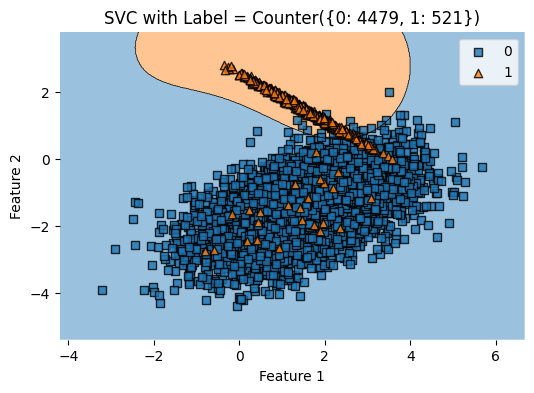

In [15]:
clf = SVC().fit(features, label)
plot_decision_regions(features, label, clf)
plt.title(f'SVC with Label = {Counter(label)}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')
plt.gcf().set_size_inches(6,4)

We see (from the title of the plot) that we have 521 anomalies and 4479 normal points. That is, 10.4% of the points are anomalies.

Let's look at the confusion matrix to see how well our classifier works.

In [16]:
cm=confusion_matrix(label, clf.predict(features))
print(cm)

[[4457   22]
 [  47  474]]


In [17]:
tn, fp, fn, tp = cm.ravel()
print(f'True Negative: {tn}')
print(f'False Positive: {fp}')
print(f'False Negative: {fn}')
print(f'True Positive: {tp}')
accuracy = accuracy_score(label, clf.predict(features))
print(f'Accuracy: {accuracy}')

True Negative: 4457
False Positive: 22
False Negative: 47
True Positive: 474
Accuracy: 0.9862


In other words, we misclassified 22 normal points and 47 anomalies. Can we do better?

**Oversampling**
As a first attempt to improve, let's oversample the anomaly class. We will use *RandomOverSampler* from *imblearn* to created a resampled training dataset.

Essential input: how much we want to oversample the anomaly class. Here we will specify the oversampling as a fraction of the size of the normal class. This fraction, *resample_ratio*, should meet two conditions:

1. It should be less than or equal to 1, so that the anomaly class always remain a minority.

2. The fraction should be large enough than the number of anomaly points in the resampled dataset is larger that the number in the original dataset. Otherwise, we will be undersampling the anomaly class.

Violating either condition produces a warning.

In [24]:
# Random oversampling of the anomaly class
resample_ratio = 0.3 # (anomalies / normal) after resampling
sample_normal = tn + fp # total number of true normal points
sample_anomaly = int(resample_ratio*sample_normal) # must be an integer
sampling_dict = {0: sample_normal, 1: sample_anomaly}
ros = RandomOverSampler(sampling_strategy=sampling_dict, random_state=42)
features_resampled, label_resampled = ros.fit_resample(features,label)

Show how many points in each class after resampling

In [25]:
Counter(label_resampled)

Counter({0: 4479, 1: 1343})

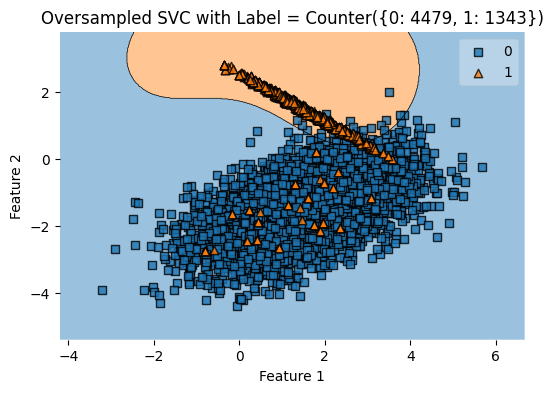

In [26]:
clf_ros = SVC().fit(features_resampled, label_resampled)
plot_decision_regions(features_resampled, label_resampled, clf_ros)
plt.title(f'Oversampled SVC with Label = {Counter(label_resampled)}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.gcf().set_size_inches(6,4)

In [27]:
cm_ros = confusion_matrix(label, clf_ros.predict(features))
cm_ros

array([[4445,   34],
       [  38,  483]])

In [28]:
tn_ros, fp_ros, fn_ros, tp_ros = cm_ros.ravel()
print('After Random Oversampling')
print(f'True Negative: {tn_ros}')
print(f'False Positive: {fp_ros}')
print(f'False Negative: {fn_ros}')
print(f'True Positive: {tp_ros}')
accuracy_ros = accuracy_score(label, clf_ros.predict(features))
print(f'Accuracy: {accuracy}')

After Random Oversampling
True Negative: 4445
False Positive: 34
False Negative: 38
True Positive: 483
Accuracy: 0.9862


Now have misclassified 34 normal points and 37 anomalies.

Previously, we misclassified 22 normal points and 47 anomalies.

Which is better?

The answer depends on the cost of misclassification.

Let us define a function that calculates this cost. In the function below, we are implicitly assuming that a correctly classified point has no cost.

In [29]:
def misclass_cost(false_pos, false_neg, false_pos_cost, false_neg_cost):
    '''
    Calculates the cost of misclassified instances

    Args:
        false_pos: number of false positives (float)
        false_neg: number of false negatives (float)
        false_pos_cost: cost of a false positive (float > 0)
        false_neg_cost: cost of a false negative (float > 0)

    Returns:
        misclass_cost: the cost of misclassifcation (float)

    Raises:
        Error: if false_pos_cost or false_neg_cost are non-positive
    '''
    if(false_pos_cost <= 0  or false_neg_cost <= 0):
        print('Costs must be greater than zero')
        return
    else:
        misclass_cost = (false_pos*false_pos_cost
                         + false_neg*false_neg_cost)
        return misclass_cost

Now to assign costs.

In [30]:
false_pos_cost = 10
false_neg_cost = 100

In [31]:
cost_reg = misclass_cost(fp, fn, false_pos_cost, false_neg_cost)
cost_ros = misclass_cost(fp_ros, fn_ros, false_pos_cost, false_neg_cost)
print(f'Without oversampling the cost is: {cost_reg}')
print(f'With random oversampling the cost is: {cost_ros}')
print('')
print(f'Accuracy without oversampling is: {accuracy}')
print(f'Accuracy with random oversampling is: {accuracy_ros}')

Without oversampling the cost is: 4920
With random oversampling the cost is: 4140

Accuracy without oversampling is: 0.9862
Accuracy with random oversampling is: 0.9856


Random oversampling has reduced the cost of misclassification despite the lower accuracy.

**Question**: What happens if the costs for false positive and false negative are equal?

**Answer**: The cost will be proportional to (1-accuracy). In other words, using accuracy as a metric is equivalent to assuming equal costs for the two categories.

**Undersampling**
Let's see how undersampling does. The structure of this section is the same as for oversampling, except that now we undersample the normal class.

As before, we have an essential input: how much we want to undersample the normal class. Here we will specify the undersampling as a multiple of the size of the anomaly class. This multiple, *resample_ratio_under*, should meet two conditions:

1. It should be greater than or equal to 1, so that the normal class always remain a majority.

2. The multiple should be small enough than the number of normal points in the resampled dataset is smaller that the number in the original dataset. Otherwise, we will be oversampling the normal class.

In [34]:
# Random undersampling of the normal class

# resample_ratio_under is (normal/anomalies) after resampling
# Should be int, but added int() later to prevent error
resample_ratio_under = 1 # a 1:1 ratio is a typical starting point

sample_anomaly_under = tp + fn

# total number of true normal points
# int is a safeguard in case resample_ratio_under is given as float
sample_normal_under = int(resample_ratio_under*sample_anomaly_under)

sampling_dict = {0: sample_normal_under, 1: sample_anomaly_under}
rus = RandomUnderSampler(sampling_strategy=sampling_dict, random_state=0)
features_resampled_2, label_resampled_2 = rus.fit_resample(features,label)

In [35]:
# Check undersampling
Counter(label_resampled_2)

Counter({0: 521, 1: 521})

In [36]:
clf_rus = SVC().fit(features_resampled_2, label_resampled_2)

In [37]:
cm_rus = confusion_matrix(label, clf_rus.predict(features))
print(cm_rus)
accuracy_rus = accuracy_score(label, clf_rus.predict(features))
tn_rus, fp_rus, fn_rus, tp_rus = cm_rus.ravel()
cost_rus = misclass_cost(fp_rus, fn_rus, false_pos_cost, false_neg_cost)
print('')
print(f'With random undersampling the cost is: {cost_rus}')
print(f'Accuracy with random undersampling is: {accuracy_rus}')

[[4388   91]
 [  27  494]]

With random undersampling the cost is: 3610
Accuracy with random undersampling is: 0.9764


Undersampling does even better than oversampling in terms of cost despite the further drop in accuracy.

## Section 3: Boosting methods
**Learning from your mistakes**
- The process of converting a family of weak learners into a strong learner.
- Weak learner = a classifier only a little better than random guessing
- Strong learner = a classifier highly correlated with the correct classification
- The weak learners are trained sequentially, each trying to correct the mistakes of its predecessor

**Popular Boosting Algorithm**
### AdaBoost
- Learning occurs through a weighted-error approach
- For each round:
    - Weight is increased for previously misclassified examples
    - Weight is increased for correctly classified ones
- Predictions for test data are obtained from a confidence-weighted majority vote of the learners from all rounds
- Typically used with decision trees, but works with any weak learner
- Can be modified to include cost-sensitive learning

As we discussed in the lecture, AdaBoost works well with any weak learner, but it most commonly used with decision trees. Therefore, it this section we will apply it to the plain tree from Section 1 (where *class_weight* is *None*) and see if it improves our results.

In [38]:
bdtree = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1,
                                                   class_weight=None),
                            n_estimators=100)

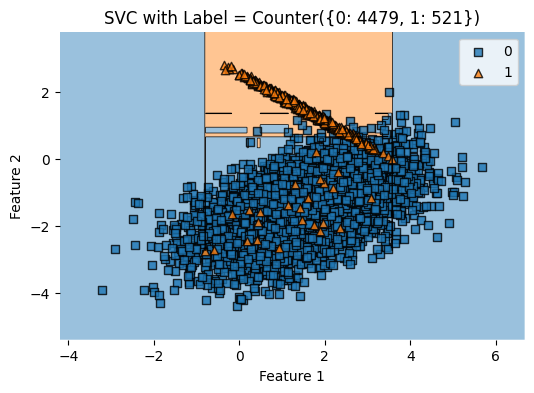

In [39]:
bdtree_fit = bdtree.fit(features, label)
plot_decision_regions(features, label, bdtree_fit)
plt.title(f'SVC with Label = {Counter(label)}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')
plt.gcf().set_size_inches(6,4)

AdaBoost has created a more complex decision boundary. It is no longer a single straight line. Have the statistics improved too?

In [40]:
cm_bdtree=confusion_matrix(label, bdtree.predict(features))
print(cm_bdtree)
accuracy_bdtree = accuracy_score(label, bdtree.predict(features))
print(f'Accuracy: {accuracy_bdtree}')

[[4460   19]
 [  43  478]]
Accuracy: 0.9876


Recall the results without boosting

In [41]:
print(cm_tree_plain)
print(f'Accuracy: {accuracy_tree_plain}')

[[4442   37]
 [  47  474]]
Accuracy: 0.9832


Boosting has increased the accuracy and even improved slightly the number of anomalies detected correctly (478 vs. 474) Useful!

### Exercise #1

This exercise refers to Section 3 (AdaBoost).

Repeat the analysis of Section 3 with the balanced decision trees (*class_weight*=*balanced*). Does boosting lead again to an improvement is anomaly detection?

### Solution #1

In [42]:
bdtree = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1,
                                                   class_weight="balanced"),
                            n_estimators=100)

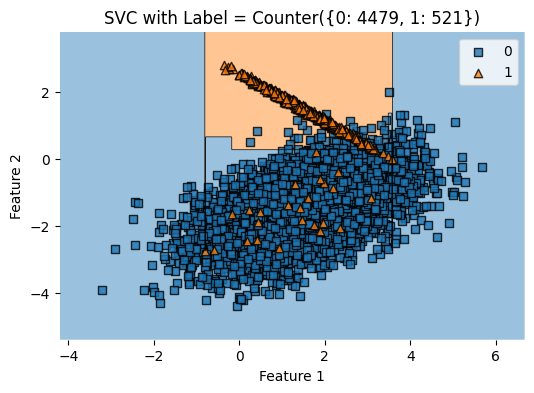

In [43]:
bdtree_fit = bdtree.fit(features, label)
plot_decision_regions(features, label, bdtree_fit)
plt.title(f'SVC with Label = {Counter(label)}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')
plt.gcf().set_size_inches(6,4)

In [44]:
cm_bdtree=confusion_matrix(label, bdtree.predict(features))
print(cm_bdtree)
accuracy_bdtree = accuracy_score(label, bdtree.predict(features))
print(f'Accuracy: {accuracy_bdtree}')

[[4412   67]
 [  23  498]]
Accuracy: 0.982
